In [9]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
perf_train = pd.read_csv('performance_train.csv').sort_values('ID_CPTE').reset_index(drop = True).loc[:1000, :]
perf_test = pd.read_csv('performance_test.csv').sort_values('ID_CPTE').reset_index(drop = True).loc[:1000, :]
fact_train = pd.read_csv('facturation_train.csv').sort_values(['ID_CPTE', 'PERIODID_MY']).reset_index(drop = True).loc[:1000, :]
fact_test = pd.read_csv('facturation_test.csv').sort_values(['ID_CPTE', 'PERIODID_MY']).reset_index(drop = True).loc[:1000, :]
pay_train = pd.read_csv('paiements_train.csv').sort_values(['ID_CPTE']).reset_index(drop = True).loc[:1000, :]
pay_test = pd.read_csv('paiements_test.csv').sort_values(['ID_CPTE']).reset_index(drop = True).loc[:1000, :]
tran_train = pd.read_csv('transactions_train.csv').sort_values(['ID_CPTE']).reset_index(drop = True).loc[:1000, :]
tran_test = pd.read_csv('transactions_test.csv').sort_values(['ID_CPTE']).reset_index(drop = True).loc[:1000, :]

In [11]:
# Add identifying column
perf_train['set'] = 'train'
perf_test['set'] = 'test'
perf_test["Default"] = np.nan
# Append the dataframes
perf = perf_train.append(perf_test, ignore_index = True)

In [12]:
# Add identifying column
pay_train['set'] = 'train'
pay_test['set'] = 'test'
# Append the dataframes
pay = pay_train.append(pay_test, ignore_index = True)

In [13]:
# Add identifying column
fact_train['set'] = 'train'
fact_test['set'] = 'test'
# Append the dataframes
fact = fact_train.append(fact_test, ignore_index = True)

In [14]:
# Add identifying column
tran_train['set'] = 'train'
tran_test['set'] = 'test'
# Append the dataframes
tran = tran_train.append(tran_test, ignore_index = True)

Featuretools Basics

In [15]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [21]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'perf', dataframe = perf, index = 'ID_CPTE')

#es = es.entity_from_dataframe(entity_id = 'fact', dataframe = fact, index = 'ID_CPTE',time_index='PERIODID_MY',  variable_types={'DelqCycle': ft.variable_types.Categorical})

#es = es.entity_from_dataframe(entity_id = 'pay', dataframe = pay, index = 'ID_CPTE',time_index='TRANSACTION_DTTM')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'fact', dataframe = fact, 
                              make_index = True, index = 'fact_index', 
                              time_index='PERIODID_MY')

es = es.entity_from_dataframe(entity_id = 'pay', dataframe = pay, 
                              make_index = True, index = 'pay_index',
                              time_index='TRANSACTION_DTTM')

es = es.entity_from_dataframe(entity_id = 'tran', dataframe = tran,
                              make_index = True, index = 'tran_index')



In [22]:
es

Entityset: clients
  Entities:
    perf [Rows: 2002, Columns: 4]
    fact [Rows: 2002, Columns: 9]
    pay [Rows: 2002, Columns: 6]
    tran [Rows: 2002, Columns: 13]
  Relationships:
    No relationships

Relationships

In [25]:
# Relationship between entities
r_perf_fact = ft.Relationship(es['perf']['ID_CPTE'], es['fact']['ID_CPTE'] )
r_perf_pay = ft.Relationship(es['perf']['ID_CPTE'], es['pay']['ID_CPTE'])
r_perf_tran = ft.Relationship(es['perf']['ID_CPTE'], es['tran']['ID_CPTE'])
r_perf_tran = ft.Relationship(es['perf']['ID_CPTE'], es['tran']['ID_CPTE'])


In [26]:
# Add in the defined relationships
es = es.add_relationships([r_perf_fact, r_perf_pay, r_perf_fact,
                           r_perf_tran])
# Print out the EntitySet
es

2018-07-08 20:48:23,143 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: fact.ID_CPTE -> perf.ID_CPTE>


Entityset: clients
  Entities:
    perf [Rows: 2002, Columns: 4]
    fact [Rows: 2002, Columns: 9]
    pay [Rows: 2002, Columns: 6]
    tran [Rows: 2002, Columns: 13]
  Relationships:
    fact.ID_CPTE -> perf.ID_CPTE
    pay.ID_CPTE -> perf.ID_CPTE
    tran.ID_CPTE -> perf.ID_CPTE

Feature Primitives

- Aggregation
- Transformation

In [27]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,description
0,time_since_last,aggregation,Time since last related instance.
1,median,aggregation,Finds the median value of any feature with well-ordered values.
2,percent_true,aggregation,Finds the percent of 'True' values in a boolean feature.
3,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
4,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
5,max,aggregation,Finds the maximum non-null value of a numeric feature.
6,mode,aggregation,Finds the most common element in a categorical feature.
7,all,aggregation,Test if all values are 'True'.
8,num_true,aggregation,Finds the number of 'True' values in a boolean.
9,min,aggregation,Finds the minimum non-null value of a numeric feature.


In [28]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,description
19,cum_mean,transform,Calculates the mean of previous values of an instance for each value in a time-dependent entity.
20,time_since,transform,Calculates time since the cutoff time.
21,second,transform,Transform a Datetime feature into the second.
22,multiply,transform,Creates a transform feature that multplies two features.
23,isin,transform,"For each value of the base feature, checks whether it is in a provided list."
24,numwords,transform,Returns the words in a given string by counting the spaces.
25,days,transform,Transform a Timedelta feature into the number of days.
26,or,transform,"For two boolean values, determine if one value is 'True'."
27,haversine,transform,Calculate the approximate haversine distance in miles between two LatLong variable types.
28,weekday,transform,Transform Datetime feature into the boolean of Weekday.


Deep Feature Synthesis

DFS with Default Primitives

In [29]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "numwords", "characters"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'perf',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

109 Total Features


In [30]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'perf',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 109 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,Default,set,SUM(tran.MERCHANT_CITY_NAME),SUM(tran.PRIOR_CREDIT_LIMIT_AMT),SUM(tran.TRANSACTION_AMT),STD(tran.MERCHANT_CITY_NAME),STD(tran.PRIOR_CREDIT_LIMIT_AMT),STD(tran.TRANSACTION_AMT),MAX(tran.MERCHANT_CITY_NAME),MAX(tran.PRIOR_CREDIT_LIMIT_AMT),MAX(tran.TRANSACTION_AMT),SKEW(tran.MERCHANT_CITY_NAME),SKEW(tran.PRIOR_CREDIT_LIMIT_AMT),SKEW(tran.TRANSACTION_AMT),MIN(tran.MERCHANT_CITY_NAME),MIN(tran.PRIOR_CREDIT_LIMIT_AMT),MIN(tran.TRANSACTION_AMT),MEAN(tran.MERCHANT_CITY_NAME),MEAN(tran.PRIOR_CREDIT_LIMIT_AMT),MEAN(tran.TRANSACTION_AMT),COUNT(tran),NUM_UNIQUE(tran.MERCHANT_CATEGORY_XCD),NUM_UNIQUE(tran.MERCHANT_COUNTRY_XCD),NUM_UNIQUE(tran.DECISION_XCD),NUM_UNIQUE(tran.TRANSACTION_CATEGORY_XCD),NUM_UNIQUE(tran.TRANSACTION_TYPE_XCD),NUM_UNIQUE(tran.SICGROUP),NUM_UNIQUE(tran.set),MODE(tran.MERCHANT_CATEGORY_XCD),MODE(tran.MERCHANT_COUNTRY_XCD),MODE(tran.DECISION_XCD),MODE(tran.TRANSACTION_CATEGORY_XCD),MODE(tran.TRANSACTION_TYPE_XCD),MODE(tran.SICGROUP),MODE(tran.set),SUM(fact.CurrentTotalBalance),SUM(fact.CashBalance),SUM(fact.CreditLimit),SUM(fact.DelqCycle),STD(fact.CurrentTotalBalance),STD(fact.CashBalance),STD(fact.CreditLimit),STD(fact.DelqCycle),MAX(fact.CurrentTotalBalance),MAX(fact.CashBalance),MAX(fact.CreditLimit),MAX(fact.DelqCycle),SKEW(fact.CurrentTotalBalance),SKEW(fact.CashBalance),SKEW(fact.CreditLimit),SKEW(fact.DelqCycle),MIN(fact.CurrentTotalBalance),MIN(fact.CashBalance),MIN(fact.CreditLimit),MIN(fact.DelqCycle),MEAN(fact.CurrentTotalBalance),MEAN(fact.CashBalance),MEAN(fact.CreditLimit),MEAN(fact.DelqCycle),COUNT(fact),NUM_UNIQUE(fact.set),MODE(fact.set),SUM(pay.TRANSACTION_AMT),STD(pay.TRANSACTION_AMT),MAX(pay.TRANSACTION_AMT),SKEW(pay.TRANSACTION_AMT),MIN(pay.TRANSACTION_AMT),MEAN(pay.TRANSACTION_AMT),COUNT(pay),NUM_UNIQUE(pay.PAYMENT_REVERSAL_XFLG),NUM_UNIQUE(pay.set),MODE(pay.PAYMENT_REVERSAL_XFLG),MODE(pay.set),DAY(PERIODID_MY),YEAR(PERIODID_MY),MONTH(PERIODID_MY),WEEKDAY(PERIODID_MY),NUM_UNIQUE(tran.DAY(TRANSACTION_DTTM)),NUM_UNIQUE(tran.YEAR(TRANSACTION_DTTM)),NUM_UNIQUE(tran.MONTH(TRANSACTION_DTTM)),NUM_UNIQUE(tran.WEEKDAY(TRANSACTION_DTTM)),MODE(tran.DAY(TRANSACTION_DTTM)),MODE(tran.YEAR(TRANSACTION_DTTM)),MODE(tran.MONTH(TRANSACTION_DTTM)),MODE(tran.WEEKDAY(TRANSACTION_DTTM)),NUM_UNIQUE(fact.DAY(PERIODID_MY)),NUM_UNIQUE(fact.DAY(StatementDate)),NUM_UNIQUE(fact.YEAR(PERIODID_MY)),NUM_UNIQUE(fact.YEAR(StatementDate)),NUM_UNIQUE(fact.MONTH(PERIODID_MY)),NUM_UNIQUE(fact.MONTH(StatementDate)),NUM_UNIQUE(fact.WEEKDAY(PERIODID_MY)),NUM_UNIQUE(fact.WEEKDAY(StatementDate)),MODE(fact.DAY(PERIODID_MY)),MODE(fact.DAY(StatementDate)),MODE(fact.YEAR(PERIODID_MY)),MODE(fact.YEAR(StatementDate)),MODE(fact.MONTH(PERIODID_MY)),MODE(fact.MONTH(StatementDate)),MODE(fact.WEEKDAY(PERIODID_MY)),MODE(fact.WEEKDAY(StatementDate)),NUM_UNIQUE(pay.DAY(TRANSACTION_DTTM)),NUM_UNIQUE(pay.YEAR(TRANSACTION_DTTM)),NUM_UNIQUE(pay.MONTH(TRANSACTION_DTTM)),NUM_UNIQUE(pay.WEEKDAY(TRANSACTION_DTTM)),MODE(pay.DAY(TRANSACTION_DTTM)),MODE(pay.YEAR(TRANSACTION_DTTM)),MODE(pay.MONTH(TRANSACTION_DTTM)),MODE(pay.WEEKDAY(TRANSACTION_DTTM))
ID_CPTE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001822,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149822.66,101.00,161000.0,0.0,1134.546934,26.011477,0.000000,0.000000,11932.20,101.00,11500.0,0.0,-0.833262,3.328201,0.000000,0.000000,8079.42,0.0,11500.0,0.0,10701.618571,7.214286,11500.000000,0.000000,14.0,1.0,train,7605.55,1016.677801,4200.00,3.299261,40.80,543.253571,14.0,1.0,1.0,Q,train,1,2014,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,2.0,2.0,12.0,10.0,7.0,6.0,1.0,3.0,2014.0,2014.0,11.0,3.0,5.0,3.0,11.0,1.0,12.0,5.0,23.0,2014.0,2.0,2.0
10007972,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4661.24,3.09,9800.0,0.0,225.996817,0.795797,0.0000

In [31]:
feature_names[-20:]

[<Feature: NUM_UNIQUE(fact.MONTH(PERIODID_MY))>,
 <Feature: NUM_UNIQUE(fact.MONTH(StatementDate))>,
 <Feature: NUM_UNIQUE(fact.WEEKDAY(PERIODID_MY))>,
 <Feature: NUM_UNIQUE(fact.WEEKDAY(StatementDate))>,
 <Feature: MODE(fact.DAY(PERIODID_MY))>,
 <Feature: MODE(fact.DAY(StatementDate))>,
 <Feature: MODE(fact.YEAR(PERIODID_MY))>,
 <Feature: MODE(fact.YEAR(StatementDate))>,
 <Feature: MODE(fact.MONTH(PERIODID_MY))>,
 <Feature: MODE(fact.MONTH(StatementDate))>,
 <Feature: MODE(fact.WEEKDAY(PERIODID_MY))>,
 <Feature: MODE(fact.WEEKDAY(StatementDate))>,
 <Feature: NUM_UNIQUE(pay.DAY(TRANSACTION_DTTM))>,
 <Feature: NUM_UNIQUE(pay.YEAR(TRANSACTION_DTTM))>,
 <Feature: NUM_UNIQUE(pay.MONTH(TRANSACTION_DTTM))>,
 <Feature: NUM_UNIQUE(pay.WEEKDAY(TRANSACTION_DTTM))>,
 <Feature: MODE(pay.DAY(TRANSACTION_DTTM))>,
 <Feature: MODE(pay.YEAR(TRANSACTION_DTTM))>,
 <Feature: MODE(pay.MONTH(TRANSACTION_DTTM))>,
 <Feature: MODE(pay.WEEKDAY(TRANSACTION_DTTM))>]

DFS with Selected Aggregation Primitives

In [32]:
 #Specify the aggregation primitives
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_entity = 'perf',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 67 features
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [33]:
# Reset the index to make SK_ID_CURR a column again                                      
feature_matrix = feature_matrix.reset_index()

print('Saving features')
feature_matrix.to_csv('feature_matrix.csv', index = False)

Saving features


In [34]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

,Default,set,SUM(tran.MERCHANT_CITY_NAME),SUM(tran.PRIOR_CREDIT_LIMIT_AMT),SUM(tran.TRANSACTION_AMT),COUNT(tran),MIN(tran.MERCHANT_CITY_NAME),MIN(tran.PRIOR_CREDIT_LIMIT_AMT),MIN(tran.TRANSACTION_AMT),MAX(tran.MERCHANT_CITY_NAME),MAX(tran.PRIOR_CREDIT_LIMIT_AMT),MAX(tran.TRANSACTION_AMT),MEAN(tran.MERCHANT_CITY_NAME),MEAN(tran.PRIOR_CREDIT_LIMIT_AMT),MEAN(tran.TRANSACTION_AMT),MODE(tran.MERCHANT_CATEGORY_XCD),MODE(tran.MERCHANT_COUNTRY_XCD),MODE(tran.DECISION_XCD),MODE(tran.TRANSACTION_CATEGORY_XCD),MODE(tran.TRANSACTION_TYPE_XCD),MODE(tran.SICGROUP),MODE(tran.set),SUM(fact.CurrentTotalBalance),SUM(fact.CashBalance),SUM(fact.CreditLimit),SUM(fact.DelqCycle),COUNT(fact),MIN(fact.CurrentTotalBalance),MIN(fact.CashBalance),MIN(fact.CreditLimit),MIN(fact.DelqCycle),MAX(fact.CurrentTotalBalance),MAX(fact.CashBalance),MAX(fact.CreditLimit),MAX(fact.DelqCycle),MEAN(fact.CurrentTotalBalance),MEAN(fact.CashBalance),MEAN(fact.CreditLimit),MEAN(fact.DelqCycle),MODE(fact.set),SUM(pay.TRANSACTION_AMT),COUNT(pay),MIN(pay.TRANSACTION_AMT),MAX(pay.TRANSACTION_AMT),MEAN(pay.TRANSACTION_AMT),MODE(pay.PAYMENT_REVERSAL_XFLG),MODE(pay.set),DAY(PERIODID_MY),YEAR(PERIODID_MY),MONTH(PERIODID_MY),WEEKDAY(PERIODID_MY),MODE(tran.DAY(TRANSACTION_DTTM)),MODE(tran.YEAR(TRANSACTION_DTTM)),MODE(tran.MONTH(TRANSACTION_DTTM)),MODE(tran.WEEKDAY(TRANSACTION_DTTM)),MODE(fact.DAY(PERIODID_MY)),MODE(fact.DAY(StatementDate)),MODE(fact.YEAR(PERIODID_MY)),MODE(fact.YEAR(StatementDate)),MODE(fact.MONTH(PERIODID_MY)),MODE(fact.MONTH(StatementDate)),MODE(fact.WEEKDAY(PERIODID_MY)),MODE(fact.WEEKDAY(StatementDate)),MODE(pay.DAY(TRANSACTION_DTTM)),MODE(pay.YEAR(TRANSACTION_DTTM)),MODE(pay.MONTH(TRANSACTION_DTTM)),MODE(pay.WEEKDAY(TRANSACTION_DTTM))
ID_CPTE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001822,0.0,train,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149822.66,101.00,161000.0,0.0,14.0,8079.42,0.0,11500.0,0.0,11932.20,101.00,11500.0,0.0,10701.618571,7.214286,11500.000000,0.000000,train,7605.55,14.0,40.80,4200.00,543.253571,Q,train,1,2014,12,0,NaN,NaN,NaN,NaN,1.0,3.0,2014.0,2014.0,11.0,3.0,5.0,3.0,23.0,2014.0,2.0,2.0
10007972,0.0,train,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4661.24,3.09,9800.0,0.0,14.0,0.00,0.0,700.0,0.0,571.34,3.09,700.0,0.0,332.945714,0.220714,700.000000,0.000000,train,12361.13,50.0,2.06,1575.00,247.222600,Q,train,1,2013,12,6,NaN,NaN,NaN,NaN,1.0,17.0,2013.0,2013.0,11.0,11.0,4.0,6.0,15.0,2013.0,12.0,6.0
10012520,0.0,train,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13255.53,5353.91,32300.0,0.0,14.0,112.20,0.0,950.0,0.0,1846.95,1224.00,3200.0,0.0,946.823571,382.422143,2307.142857,0.000000,train,7165.91,15.0,50.50,1070.00,477.727333,Q,train,1,2014,12,0,NaN,NaN,NaN,NaN,1.0,17.0,2014.0,2014.0,11.0,11.0,5.0,0.0,7.0,2014.0,4.0,3.0
10025534,1.0,train,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81032.22,0.00,85400.0,6.0,14.0,1274.11,0.0,6100.0,0.0,6687.50,0.00,6100.0,1.0,5788.015714,0.000000,6100.000000,0.428571,train,9477.30,6.0,131.30,6264.00,1579.550000,Q,train,1,2013,12,6,NaN,NaN,NaN,NaN,1.0,27.0,2013.0,2013.0,11.0,11.0,4.0,5.0,21.0,2013.0,1.0,6.0
10033579,0.0,train,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5772.15,65.44,7000.0,1.0,14.0,57.78,0.0,500.0,0.0,629.33,42.84,500.0,1.0,412.296429,4.674286,500.000000,0.071429,train,3636.07,44.0,5.10,157.50,82.637955,Q,train,1,2015,12,1,NaN,NaN,NaN,NaN,1.0,3.0,2015.0,2015.0,11.0,1.0,6.0,4.0,5.0,2015.0,1.0,4.0
10034823,0.0,train,840113504.0,347956.0,11255.23,345.0,110977.0,-357.0,0.00,2734290.0,1800.0,860.28,2.435112e+06,1008.568116,32.623855,KK,DP,C,E,F,AT,train,14231.74,0.00,25200.0,4.0,14.0,182.32,0.0,1800.0,0.0,2311.86,0.00,1800.0,1.0,1016.552857,0.000000,1800.000000,0.285714,train,9890.93,9.0,352.03,2182.00,1098.992222,Q,train,1,2012,12,5,18.0,2012.0,12.0,4.0,1.0,3.0,2012.0,2012.0,11.0,11.0,3.0,4.0,

In [35]:
corrs_spec=feature_matrix_spec.corr()
corrs = corrs_spec.sort_values('Default', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['Default'].head(10))

,Default
Default,1.000000
MODE(tran.YEAR(TRANSACTION_DTTM)),0.866025
MIN(tran.MERCHANT_CITY_NAME),0.801349
MAX(fact.DelqCycle),0.639435
MEAN(fact.DelqCycle),0.603451
SUM(fact.DelqCycle),0.603451
MODE(pay.YEAR(TRANSACTION_DTTM)),0.318749
MAX(fact.CashBalance),0.293584
MODE(pay.MONTH(TRANSACTION_DTTM)),0.214885
MODE(fact.DAY(StatementDate)),0.189080


In [36]:
correlations_target = corrs.sort_values('Default')['Default']
# Most negative correlations
correlations_target.head()

MEAN(tran.PRIOR_CREDIT_LIMIT_AMT)   -0.950958
SUM(tran.PRIOR_CREDIT_LIMIT_AMT)    -0.863651
MAX(tran.PRIOR_CREDIT_LIMIT_AMT)    -0.723558
MEAN(tran.MERCHANT_CITY_NAME)       -0.710883
SUM(tran.TRANSACTION_AMT)           -0.690095
Name: Default, dtype: float64

In [37]:
# Most positive correlations
correlations_target.dropna().tail(10)

MODE(fact.DAY(StatementDate))        0.189080
MODE(pay.MONTH(TRANSACTION_DTTM))    0.214885
MAX(fact.CashBalance)                0.293584
MODE(pay.YEAR(TRANSACTION_DTTM))     0.318749
SUM(fact.DelqCycle)                  0.603451
MEAN(fact.DelqCycle)                 0.603451
MAX(fact.DelqCycle)                  0.639435
MIN(tran.MERCHANT_CITY_NAME)         0.801349
MODE(tran.YEAR(TRANSACTION_DTTM))    0.866025
Default                              1.000000
Name: Default, dtype: float64

### Visualize Distribution of Correlated Variables

In [38]:
features_sample=feature_matrix
features_sample = features_sample[features_sample['set'] == 'train']
features_sample.head()

,ID_CPTE,Default,set,SUM(tran.MERCHANT_CITY_NAME),SUM(tran.PRIOR_CREDIT_LIMIT_AMT),SUM(tran.TRANSACTION_AMT),STD(tran.MERCHANT_CITY_NAME),STD(tran.PRIOR_CREDIT_LIMIT_AMT),STD(tran.TRANSACTION_AMT),MAX(tran.MERCHANT_CITY_NAME),MAX(tran.PRIOR_CREDIT_LIMIT_AMT),MAX(tran.TRANSACTION_AMT),SKEW(tran.MERCHANT_CITY_NAME),SKEW(tran.PRIOR_CREDIT_LIMIT_AMT),SKEW(tran.TRANSACTION_AMT),MIN(tran.MERCHANT_CITY_NAME),MIN(tran.PRIOR_CREDIT_LIMIT_AMT),MIN(tran.TRANSACTION_AMT),MEAN(tran.MERCHANT_CITY_NAME),MEAN(tran.PRIOR_CREDIT_LIMIT_AMT),MEAN(tran.TRANSACTION_AMT),COUNT(tran),NUM_UNIQUE(tran.MERCHANT_CATEGORY_XCD),NUM_UNIQUE(tran.MERCHANT_COUNTRY_XCD),NUM_UNIQUE(tran.DECISION_XCD),NUM_UNIQUE(tran.TRANSACTION_CATEGORY_XCD),NUM_UNIQUE(tran.TRANSACTION_TYPE_XCD),NUM_UNIQUE(tran.SICGROUP),NUM_UNIQUE(tran.set),MODE(tran.MERCHANT_CATEGORY_XCD),MODE(tran.MERCHANT_COUNTRY_XCD),MODE(tran.DECISION_XCD),MODE(tran.TRANSACTION_CATEGORY_XCD),MODE(tran.TRANSACTION_TYPE_XCD),MODE(tran.SICGROUP),MODE(tran.set),SUM(fact.CurrentTotalBalance),SUM(fact.CashBalance),SUM(fact.CreditLimit),SUM(fact.DelqCycle),STD(fact.CurrentTotalBalance),STD(fact.CashBalance),STD(fact.CreditLimit),STD(fact.DelqCycle),MAX(fact.CurrentTotalBalance),MAX(fact.CashBalance),MAX(fact.CreditLimit),MAX(fact.DelqCycle),SKEW(fact.CurrentTotalBalance),SKEW(fact.CashBalance),SKEW(fact.CreditLimit),SKEW(fact.DelqCycle),MIN(fact.CurrentTotalBalance),MIN(fact.CashBalance),MIN(fact.CreditLimit),MIN(fact.DelqCycle),MEAN(fact.CurrentTotalBalance),MEAN(fact.CashBalance),MEAN(fact.CreditLimit),MEAN(fact.DelqCycle),COUNT(fact),NUM_UNIQUE(fact.set),MODE(fact.set),SUM(pay.TRANSACTION_AMT),STD(pay.TRANSACTION_AMT),MAX(pay.TRANSACTION_AMT),SKEW(pay.TRANSACTION_AMT),MIN(pay.TRANSACTION_AMT),MEAN(pay.TRANSACTION_AMT),COUNT(pay),NUM_UNIQUE(pay.PAYMENT_REVERSAL_XFLG),NUM_UNIQUE(pay.set),MODE(pay.PAYMENT_REVERSAL_XFLG),MODE(pay.set),DAY(PERIODID_MY),YEAR(PERIODID_MY),MONTH(PERIODID_MY),WEEKDAY(PERIODID_MY),NUM_UNIQUE(tran.DAY(TRANSACTION_DTTM)),NUM_UNIQUE(tran.YEAR(TRANSACTION_DTTM)),NUM_UNIQUE(tran.MONTH(TRANSACTION_DTTM)),NUM_UNIQUE(tran.WEEKDAY(TRANSACTION_DTTM)),MODE(tran.DAY(TRANSACTION_DTTM)),MODE(tran.YEAR(TRANSACTION_DTTM)),MODE(tran.MONTH(TRANSACTION_DTTM)),MODE(tran.WEEKDAY(TRANSACTION_DTTM)),NUM_UNIQUE(fact.DAY(PERIODID_MY)),NUM_UNIQUE(fact.DAY(StatementDate)),NUM_UNIQUE(fact.YEAR(PERIODID_MY)),NUM_UNIQUE(fact.YEAR(StatementDate)),NUM_UNIQUE(fact.MONTH(PERIODID_MY)),NUM_UNIQUE(fact.MONTH(StatementDate)),NUM_UNIQUE(fact.WEEKDAY(PERIODID_MY)),NUM_UNIQUE(fact.WEEKDAY(StatementDate)),MODE(fact.DAY(PERIODID_MY)),MODE(fact.DAY(StatementDate)),MODE(fact.YEAR(PERIODID_MY)),MODE(fact.YEAR(StatementDate)),MODE(fact.MONTH(PERIODID_MY)),MODE(fact.MONTH(StatementDate)),MODE(fact.WEEKDAY(PERIODID_MY)),MODE(fact.WEEKDAY(StatementDate)),NUM_UNIQUE(pay.DAY(TRANSACTION_DTTM)),NUM_UNIQUE(pay.YEAR(TRANSACTION_DTTM)),NUM_UNIQUE(pay.MONTH(TRANSACTION_DTTM)),NUM_UNIQUE(pay.WEEKDAY(TRANSACTION_DTTM)),MODE(pay.DAY(TRANSACTION_DTTM)),MODE(pay.YEAR(TRANSACTION_DTTM)),MODE(pay.MONTH(TRANSACTION_DTTM)),MODE(pay.WEEKDAY(TRANSACTION_DTTM))
0,10001822,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149822.66,101.00,161000.0,0.0,1134.546934,26.011477,0.000000,0.000000,11932.20,101.00,11500.0,0.0,-0.833262,3.328201,0.000000,0.000000,8079.42,0.0,11500.0,0.0,10701.618571,7.214286,11500.000000,0.000000,14.0,1.0,train,7605.55,1016.677801,4200.0,3.299261,40.80,543.253571,14.0,1.0,1.0,Q,train,1,2014,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,2.0,2.0,12.0,10.0,7.0,6.0,1.0,3.0,2014.0,2014.0,11.0,3.0,5.0,3.0,11.0,1.0,12.0,5.0,23.0,2014.0,2.0,2.0
1,10007972,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4661.24,3.09,9800.0,0.0,225.996817,0.795797,0.000000,0.000000,571.34,3.09,700.0,0.0,-0.448527,3.328201,0.000000,0.000000,0.00,0.0,700.0,0.0,332.945714,0.220

In [39]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['Default'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['Default'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

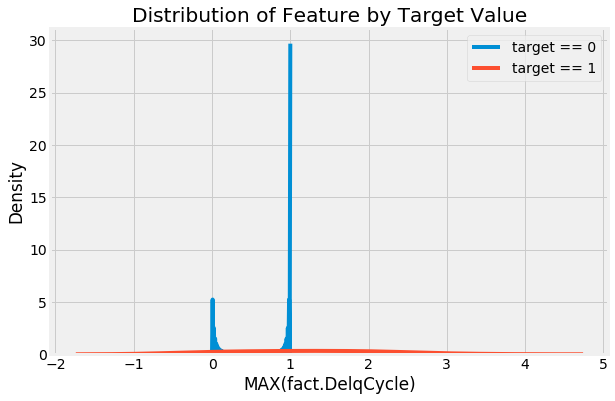

In [40]:
kde_target_plot(features_sample, feature = 'MAX(fact.DelqCycle)')

### Collinear Features

In [41]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in corrs:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corrs.index[corrs[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

Results
To determine whether our basic implementation of featuretools was useful, we can look at several results:

Cross validation scores and public leaderboard scores using several different sets of features.
Correlations: both between the features and the TARGET, and between features themselves
Feature importances: determined by a gradient boosting machine model

Correlations

In [42]:
from featuretools import selection

# Remove features with only one unique value
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('Removed %d features' % (feature_matrix.shape[1]- feature_matrix2.shape[1]))

Removed 2 features


In [45]:
# Separate out the train and test sets
train = feature_matrix2[feature_matrix2['set'] == 'train']
test = feature_matrix2[feature_matrix2['set'] == 'test']


# Align dataframes on the columns
train, test = train.align(test, join = 'inner', axis = 1)
test = test.drop(columns = ['Default'])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (1001, 108)
Final Testing Shape:  (1001, 107)


In [46]:
#train=train[['MEAN(fact.CashBalance)','MODE(pay.WEEKDAY(TRANSACTION_DTTM))','MODE(fact.DAY(StatementDate))','MODE(pay.MONTH(TRANSACTION_DTTM))','MAX(fact.CashBalance)','MODE(pay.YEAR(TRANSACTION_DTTM))','SUM(fact.DelqCycle)','MEAN(fact.DelqCycle)','MAX(fact.DelqCycle)','Default','ID_CPTE']]

In [47]:
#test=test[['MEAN(fact.CashBalance)','MODE(pay.WEEKDAY(TRANSACTION_DTTM))','MODE(fact.DAY(StatementDate))','MODE(pay.MONTH(TRANSACTION_DTTM))','MAX(fact.CashBalance)','MODE(pay.YEAR(TRANSACTION_DTTM))','SUM(fact.DelqCycle)','MEAN(fact.DelqCycle)','MAX(fact.DelqCycle)','ID_CPTE']]

In [48]:
train.head()

,ID_CPTE,Default,set,SUM(tran.MERCHANT_CITY_NAME),SUM(tran.PRIOR_CREDIT_LIMIT_AMT),SUM(tran.TRANSACTION_AMT),STD(tran.MERCHANT_CITY_NAME),STD(tran.PRIOR_CREDIT_LIMIT_AMT),STD(tran.TRANSACTION_AMT),MAX(tran.MERCHANT_CITY_NAME),MAX(tran.PRIOR_CREDIT_LIMIT_AMT),MAX(tran.TRANSACTION_AMT),SKEW(tran.MERCHANT_CITY_NAME),SKEW(tran.PRIOR_CREDIT_LIMIT_AMT),SKEW(tran.TRANSACTION_AMT),MIN(tran.MERCHANT_CITY_NAME),MIN(tran.PRIOR_CREDIT_LIMIT_AMT),MIN(tran.TRANSACTION_AMT),MEAN(tran.MERCHANT_CITY_NAME),MEAN(tran.PRIOR_CREDIT_LIMIT_AMT),MEAN(tran.TRANSACTION_AMT),COUNT(tran),NUM_UNIQUE(tran.MERCHANT_CATEGORY_XCD),NUM_UNIQUE(tran.MERCHANT_COUNTRY_XCD),NUM_UNIQUE(tran.DECISION_XCD),NUM_UNIQUE(tran.TRANSACTION_CATEGORY_XCD),NUM_UNIQUE(tran.TRANSACTION_TYPE_XCD),NUM_UNIQUE(tran.SICGROUP),NUM_UNIQUE(tran.set),MODE(tran.MERCHANT_CATEGORY_XCD),MODE(tran.MERCHANT_COUNTRY_XCD),MODE(tran.DECISION_XCD),MODE(tran.TRANSACTION_CATEGORY_XCD),MODE(tran.TRANSACTION_TYPE_XCD),MODE(tran.SICGROUP),MODE(tran.set),SUM(fact.CurrentTotalBalance),SUM(fact.CashBalance),SUM(fact.CreditLimit),SUM(fact.DelqCycle),STD(fact.CurrentTotalBalance),STD(fact.CashBalance),STD(fact.CreditLimit),STD(fact.DelqCycle),MAX(fact.CurrentTotalBalance),MAX(fact.CashBalance),MAX(fact.CreditLimit),MAX(fact.DelqCycle),SKEW(fact.CurrentTotalBalance),SKEW(fact.CashBalance),SKEW(fact.CreditLimit),SKEW(fact.DelqCycle),MIN(fact.CurrentTotalBalance),MIN(fact.CashBalance),MIN(fact.CreditLimit),MIN(fact.DelqCycle),MEAN(fact.CurrentTotalBalance),MEAN(fact.CashBalance),MEAN(fact.CreditLimit),MEAN(fact.DelqCycle),COUNT(fact),NUM_UNIQUE(fact.set),MODE(fact.set),SUM(pay.TRANSACTION_AMT),STD(pay.TRANSACTION_AMT),MAX(pay.TRANSACTION_AMT),SKEW(pay.TRANSACTION_AMT),MIN(pay.TRANSACTION_AMT),MEAN(pay.TRANSACTION_AMT),COUNT(pay),NUM_UNIQUE(pay.PAYMENT_REVERSAL_XFLG),NUM_UNIQUE(pay.set),MODE(pay.PAYMENT_REVERSAL_XFLG),MODE(pay.set),YEAR(PERIODID_MY),WEEKDAY(PERIODID_MY),NUM_UNIQUE(tran.DAY(TRANSACTION_DTTM)),NUM_UNIQUE(tran.YEAR(TRANSACTION_DTTM)),NUM_UNIQUE(tran.MONTH(TRANSACTION_DTTM)),NUM_UNIQUE(tran.WEEKDAY(TRANSACTION_DTTM)),MODE(tran.DAY(TRANSACTION_DTTM)),MODE(tran.YEAR(TRANSACTION_DTTM)),MODE(tran.MONTH(TRANSACTION_DTTM)),MODE(tran.WEEKDAY(TRANSACTION_DTTM)),NUM_UNIQUE(fact.DAY(PERIODID_MY)),NUM_UNIQUE(fact.DAY(StatementDate)),NUM_UNIQUE(fact.YEAR(PERIODID_MY)),NUM_UNIQUE(fact.YEAR(StatementDate)),NUM_UNIQUE(fact.MONTH(PERIODID_MY)),NUM_UNIQUE(fact.MONTH(StatementDate)),NUM_UNIQUE(fact.WEEKDAY(PERIODID_MY)),NUM_UNIQUE(fact.WEEKDAY(StatementDate)),MODE(fact.DAY(PERIODID_MY)),MODE(fact.DAY(StatementDate)),MODE(fact.YEAR(PERIODID_MY)),MODE(fact.YEAR(StatementDate)),MODE(fact.MONTH(PERIODID_MY)),MODE(fact.MONTH(StatementDate)),MODE(fact.WEEKDAY(PERIODID_MY)),MODE(fact.WEEKDAY(StatementDate)),NUM_UNIQUE(pay.DAY(TRANSACTION_DTTM)),NUM_UNIQUE(pay.YEAR(TRANSACTION_DTTM)),NUM_UNIQUE(pay.MONTH(TRANSACTION_DTTM)),NUM_UNIQUE(pay.WEEKDAY(TRANSACTION_DTTM)),MODE(pay.DAY(TRANSACTION_DTTM)),MODE(pay.YEAR(TRANSACTION_DTTM)),MODE(pay.MONTH(TRANSACTION_DTTM)),MODE(pay.WEEKDAY(TRANSACTION_DTTM))
0,10001822,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149822.66,101.00,161000.0,0.0,1134.546934,26.011477,0.000000,0.000000,11932.20,101.00,11500.0,0.0,-0.833262,3.328201,0.000000,0.000000,8079.42,0.0,11500.0,0.0,10701.618571,7.214286,11500.000000,0.000000,14.0,1.0,train,7605.55,1016.677801,4200.0,3.299261,40.80,543.253571,14.0,1.0,1.0,Q,train,2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,2.0,2.0,12.0,10.0,7.0,6.0,1.0,3.0,2014.0,2014.0,11.0,3.0,5.0,3.0,11.0,1.0,12.0,5.0,23.0,2014.0,2.0,2.0
1,10007972,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4661.24,3.09,9800.0,0.0,225.996817,0.795797,0.000000,0.000000,571.34,3.09,700.0,0.0,-0.448527,3.328201,0.000000,0.000000,0.00,0.0,700.0,0.0,332.945714,0.220714,700.000000,0.000000,14.0,1.0,train,12

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1441
Columns: 108 entries, ID_CPTE to MODE(pay.WEEKDAY(TRANSACTION_DTTM))
dtypes: float64(94), int64(3), object(11)
memory usage: 852.4+ KB


### Appendix: GBM Model (Used Across Feature Sets)

In [192]:

# Extract the ids
train_ids =train['ID_CPTE']
test_ids = test['ID_CPTE']

# Extract the labels for training
labels = train['Default']

# Remove the ids and target
features = train.drop(columns = ['ID_CPTE', 'Default'])
test_features = test.drop(columns = ['ID_CPTE'])


In [193]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [209]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in perf_train:
    if perf_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(perf_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(features[col])
            # Transform both training and testing data
            features[col] = le.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
            test_features[col] = le.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [215]:
features = pd.get_dummies(features)
test_features = pd.get_dummies(test_features)

Exception: Data must be 1-dimensional

In [210]:
print('Training Data Shape: ', features.shape)
print('Testing Data Shape: ', test_features.shape)

Training Data Shape:  (1001, 9)
Testing Data Shape:  (1001, 9)


In [211]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
n_folds = 5
# Convert to np arrays
features = np.array(features)
test_features = np.array(test_features)

    # Create the kfold object
k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

    # Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
valid_scores = []
train_scores = []

In [212]:
 # Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
    train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
    valid_features, valid_labels = features[valid_indices], labels[valid_indices]


In [213]:
 # Create the model    
LGBM = lgb.LGBMClassifier(n_estimators=10000, boosting_type = 'goss',
                          objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)

        # Train the model
LGBM.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)


ValueError: Unknown label type: 'continuous'

In [90]:
# Record the best iteration
best_iteration = model.best_iteration_

# Record the feature importances
feature_importance_values += model.feature_importances_ / k_fold.n_splits

# Make predictions
test_predictions += model.predict(test_features, num_iteration = best_iteration)/ k_fold.n_splits

# Record the out of fold predictions
out_of_fold[valid_indices] = model.predict(valid_features, num_iteration = best_iteration)

# Record the best score
valid_score = model.best_score_['valid']['auc']
train_score = model.best_score_['train']['auc']

valid_scores.append(valid_score)
train_scores.append(train_score)

AttributeError: 'function' object has no attribute 'best_iteration_'

In [78]:
# Record the feature importances
feature_importance_values += model.feature_importances_ / k_fold.n_splits

AttributeError: 'function' object has no attribute 'feature_importances_'

In [83]:
# Make predictions
test_predictions += model.predict(test_features, num_iteration = best_iteration)/ k_fold.n_splits

AttributeError: 'function' object has no attribute 'predict'

In [91]:
# Record the out of fold predictions
out_of_fold[valid_indices] = model.predict(valid_features, num_iteration = best_iteration)


AttributeError: 'function' object has no attribute 'predict'

In [94]:
# Record the best score
valid_score = model.best_score_['valid']['auc']
train_score = model.best_score_['train']['auc']

valid_scores.append(valid_score)
train_scores.append(train_score)

AttributeError: 'function' object has no attribute 'best_score_'

In [ ]:
# Make the submission dataframe
    submission = pd.DataFrame({'ID_CPTE': test_ids, 'Default': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 

    return submission, feature_importances, metrics